In [13]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
from sklearn import tree
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

df = pd.read_csv('winequalityN.csv')
print('Shape:', df.shape)
df.head()

Shape: (6497, 13)


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [14]:
print('Missing values per column:\n', df.isnull().sum())

Missing values per column:
 type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64


In [15]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode().iat[0])
    else:
        df[col] = df[col].fillna(df[col].median())

print('Missing values after filling:\n', df.isnull().sum())

Missing values after filling:
 type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [16]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)
df['quality_label'] = (df['quality'] >= 7).astype(int)
df['quality_label'].value_counts()

quality_label
0    5220
1    1277
Name: count, dtype: int64

In [17]:
pipe = Pipeline([('scaler', StandardScaler()), ('clf', DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=7, min_samples_split=5, min_samples_leaf=2))])

X = df.drop(columns=['quality','quality_label'])
y = df['quality_label']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
pipe.fit(X_train, y_train)
print('Model trained.')

Model trained.


In [18]:
y_pred = pipe.predict(X_test)
try:
    y_proba = pipe.predict_proba(X_test)[:,1]
except Exception:
    y_proba = None

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, zero_division=0))
print('Recall:', recall_score(y_test, y_pred, zero_division=0))
print('F1:', f1_score(y_test, y_pred, zero_division=0))
print('\nClassification report:\n', classification_report(y_test, y_pred, zero_division=0))
print('\nConfusion matrix:\n', confusion_matrix(y_test, y_pred))
if y_proba is not None:
    print('ROC-AUC:', roc_auc_score(y_test, y_proba))

Accuracy: 0.8238461538461539
Precision: 0.5627906976744186
Recall: 0.47265625
F1: 0.5138004246284501

Classification report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.89      1044
           1       0.56      0.47      0.51       256

    accuracy                           0.82      1300
   macro avg       0.72      0.69      0.70      1300
weighted avg       0.81      0.82      0.82      1300


Confusion matrix:
 [[950  94]
 [135 121]]
ROC-AUC: 0.8296029394157088


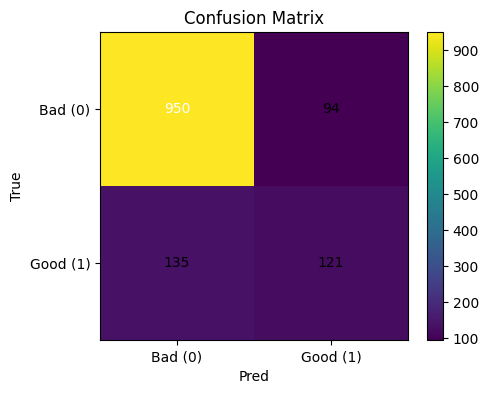

In [19]:
# Visualizations

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0,1], ['Bad (0)','Good (1)'])
plt.yticks([0,1], ['Bad (0)','Good (1)'])
th = cm.max()/2.
for i,j in np.ndindex(cm.shape):
    plt.text(j,i,cm[i,j],ha='center',va='center',color='white' if cm[i,j]>th else 'black')
plt.ylabel('True')
plt.xlabel('Pred')
plt.show()

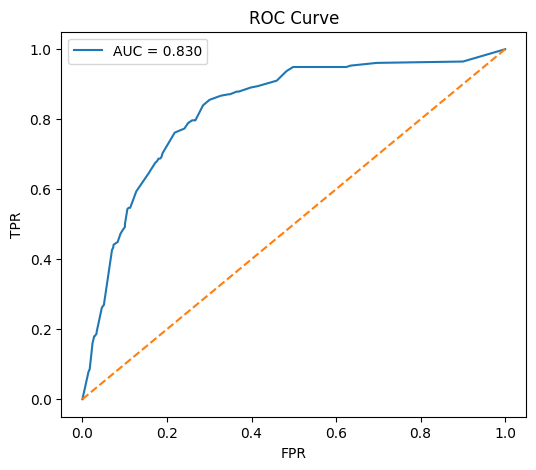

In [ ]:
if y_proba is not None:
    fpr, tpr, thr = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6,5))
    plt.plot(fpr,tpr,label=f'AUC = {roc_auc_score(y_test,y_proba):.3f}')
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

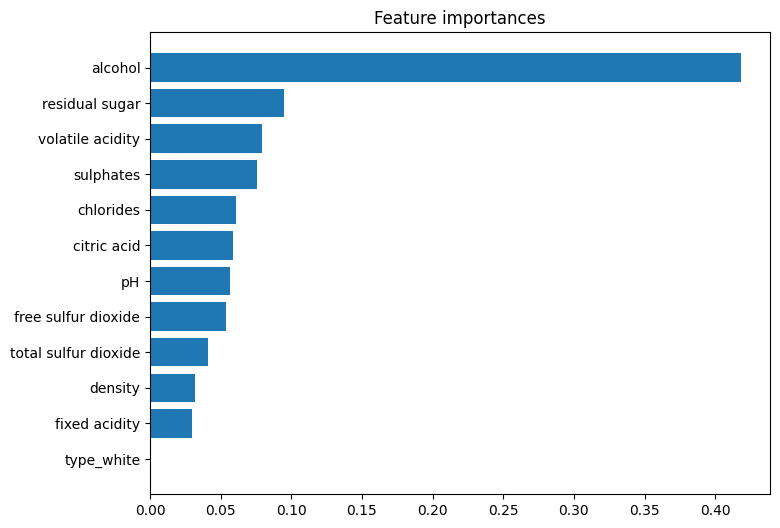

In [ ]:
# Feature importances
features = X.columns.tolist()
importances = pipe.named_steps['clf'].feature_importances_

fi_df = pd.DataFrame({'feature':features,'importance':importances}).sort_values('importance',ascending=False)
plt.figure(figsize=(8,6))
plt.barh(fi_df['feature'], fi_df['importance'])
plt.gca().invert_yaxis()
plt.title('Feature importances')
plt.show()

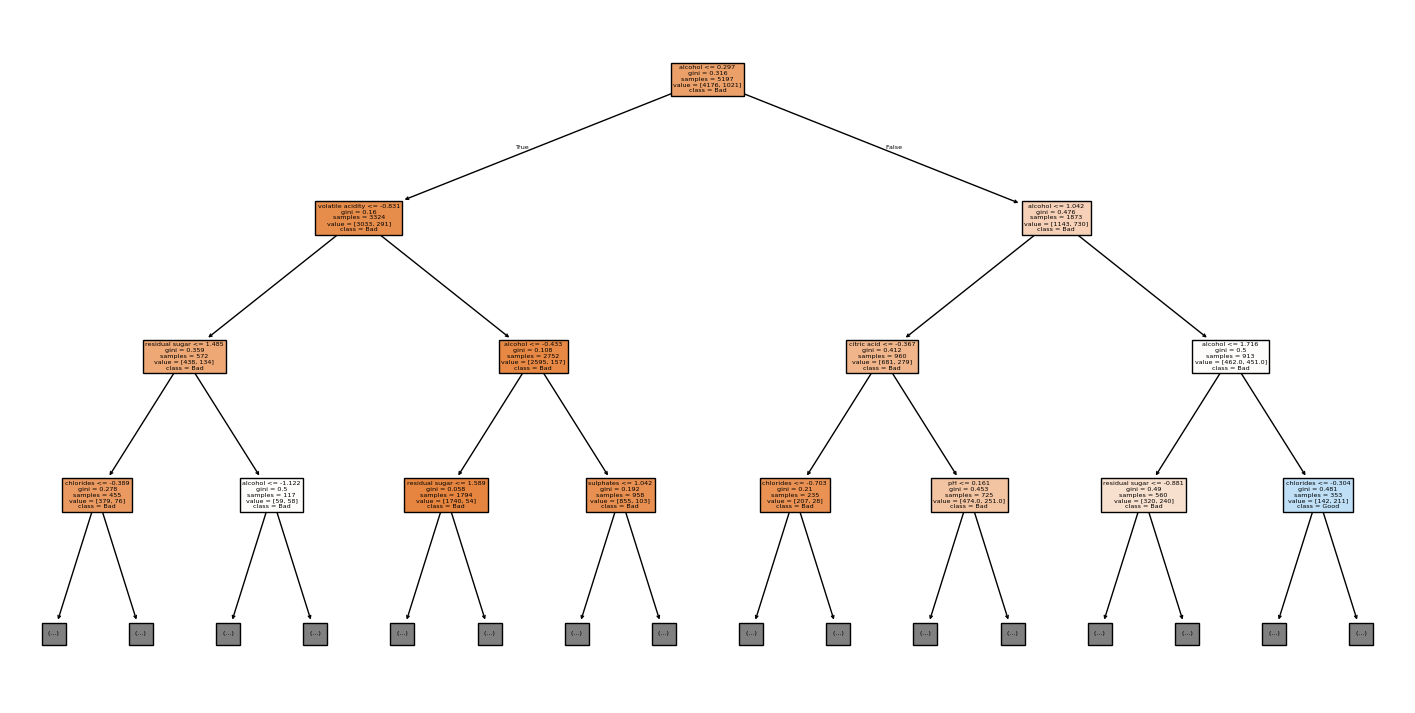

In [22]:
# Decision tree (limited depth)
plt.figure(figsize=(18,9))
tree.plot_tree(pipe.named_steps['clf'], feature_names=features, class_names=['Bad','Good'], filled=True, max_depth=3)
plt.show()

### Conclusion

The Decision Tree Classifier achieved an overall accuracy of ~82% on the test set, with a ROC-AUC of ~0.83, indicating reasonably good separability between "Good" and "Bad" wines.

Strengths:

The model performs very well on the majority class (Bad wines, label 0), with precision = 0.88 and recall = 0.91.

The ROC-AUC > 0.8 suggests the model has learned meaningful patterns in the data.

Limiting the tree depth to 7 prevented severe overfitting while still capturing important relationships.

Weaknesses:

Performance on the minority class (Good wines, label 1) is weaker: precision = 0.56, recall = 0.47, and F1 = 0.51.

The confusion matrix shows many Good wines misclassified as Bad (135 out of 256).

This imbalance occurs because the dataset is skewed toward Bad wines (majority class).

Feature importance:

alcohol is by far the most important feature, followed by residual sugar, volatile acidity, and sulphates. This aligns with domain intuition: higher alcohol and balanced acidity typically indicate better quality wines.

Overfitting/Underfitting:

The controlled depth indicates reduced overfitting compared to an unrestricted tree. However, recall for the minority class suggests some underfitting, i.e., the model could not fully capture the subtle patterns distinguishing Good wines.